In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "prompt-sweep-1.json",
    "prompt-sweep-2.json",
    "prompt-sweep-3.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

114 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'technique': 'standard'},
  'run': 1,
  'train': {'dataset': {'path': 'bdsaglam/musique-mini',
    'name': 'answerable',
    'split': 'train'},
   'optimizer': 'noop'},
  'evaluation': {'dataset': {'path': 'bdsaglam/musique',
    'name': 'answerable',
    'split': 'validation'}}},
 'metrics': {'exact_match': 0.55,
  'f1': 0.6629834609834611,
  'fuzzy_match': 0.61,
  '2hops': {'exact_match': 0.6, 'f1': 0.7348075258075258, 'fuzzy_match': 0.68},
  '3hops': {'exact_match': 0.59,
   'f1': 0.6825476190476191,
   'fuzzy_match': 0.64},
  '4hops': {'exact_match': 0.46,
   'f1': 0.5715952380952382,
   'fuzzy_match': 0.51}}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])

param_cols = [
    "params.dataset.path",
    "params.dataset.name",
    "params.dataset.split",
    "params.qa.model",
    "params.qa.temperature",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.run",
]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

df = df.sort_values(
    [
        "params.qa.model",
        "params.qa.system_prompt",
        "params.qa.user_prompt_template",
        "params.qa.few_shot_examples",
        "params.run",
    ]
)
df = df[df["params.dataset.path"] == "bdsaglam/musique"].copy()
df.reset_index(drop=True, inplace=True)
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")

In [4]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [5]:
df['params.qa.few_shot_examples'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [6]:
df['params.qa.system_prompt'].unique().tolist()

['cot.txt',
 'cot/format-reasoning.txt',
 'cot/format-role-detailed.txt',
 'cot/format-think.txt',
 'cot/minimal.txt',
 'cte.txt',
 'excellent-qa-cot.txt',
 'excellent-qa-cte.txt',
 'excellent-qa-few.txt',
 'excellent-qa-fewest.txt',
 'minimal-output-format-answer-cue-least.txt',
 'minimal-output-format-answer-cue.txt',
 'minimal-output-format-answer-few-no-prio.txt',
 'minimal-output-format.txt',
 'minimal.txt']

In [7]:
# mapping = {
#     'minimal.txt': 'm',
#     'minimal-output-format.txt': 'm-o',
#     'minimal-output-format-answer-cue.txt': 'm-o-few',
#     'minimal-output-format-answer-cue-least.txt': 'm-o-fewest',
#     'minimal-output-format-answer-few-no-prio.txt': 'm-o-few-no-prio',
#     'excellent-qa-few.txt': 'exc-few',
#     'excellent-qa-fewest.txt': 'exc-fewest',
#     'excellent-qa-cot.txt': 'exc-cot',
#     'excellent-qa-cte.txt': 'exc-cte',
#     'cte.txt': 'cte',
#     'cot.txt': 'cot',
# }
# df['params.qa.system_prompt'] = df['params.qa.system_prompt'].map(lambda x: mapping.get(x, x))

In [8]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [9]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols
    ]
    .mean()
    .reset_index()
)
df_avg[["params.qa.system_prompt", 'params.qa.user_prompt_template', "params.qa.few_shot_examples", *metric_cols]].sort_values('metrics.2hops.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
17,cte.txt,cq.txt,2,0.627224,0.743187,0.684181,0.660277,0.767688,0.723642,0.634211,0.768743,0.689035,0.511934,0.619488,0.553086
19,excellent-qa-cte.txt,cq.txt,2,0.648738,0.751376,0.700041,0.666134,0.766371,0.721778,0.670175,0.783806,0.719298,0.554733,0.644163,0.596708
28,minimal-output-format-answer-cue.txt,cq.txt,2,0.595918,0.711330,0.657702,0.638978,0.746748,0.709798,0.566228,0.701321,0.633772,0.518519,0.620622,0.541564
21,excellent-qa-few.txt,cq.txt,2,0.599779,0.709603,0.657978,0.637114,0.741893,0.709531,0.582018,0.705804,0.632895,0.517695,0.616911,0.545679
32,minimal-output-format.txt,cq.txt,2,0.575093,0.691948,0.638808,0.618477,0.741548,0.691161,0.553947,0.675616,0.622368,0.480658,0.569264,0.507819
23,excellent-qa-fewest.txt,cq.txt,2,0.602813,0.702008,0.660874,0.635250,0.738326,0.704207,0.596491,0.692808,0.646491,0.514403,0.607001,0.553909
27,minimal-output-format-answer-cue.txt,cq.txt,0,0.573714,0.699545,0.642670,0.621140,0.737700,0.694622,0.550439,0.706664,0.641228,0.470782,0.568233,0.484774
26,minimal-output-format-answer-cue.txt,cq-sep.txt,0,0.569852,0.693551,0.642256,0.622204,0.735943,0.698349,0.541228,0.692944,0.635965,0.461728,0.563641,0.480658
16,cte.txt,cq.txt,0,0.587643,0.701567,0.651083,0.621938,0.729751,0.684505,0.589035,0.719814,0.665789,0.479012,0.580201,0.520165
20,excellent-qa-few.txt,cq.txt,0,0.568749,0.688877,0.636464,0.615815,0.729576,0.689031,0.549123,0.694474,0.631140,0.460082,0.552562,0.483951


In [10]:
df_target = df_avg.copy()
df_target.sort_values('metrics.f1', inplace=True)

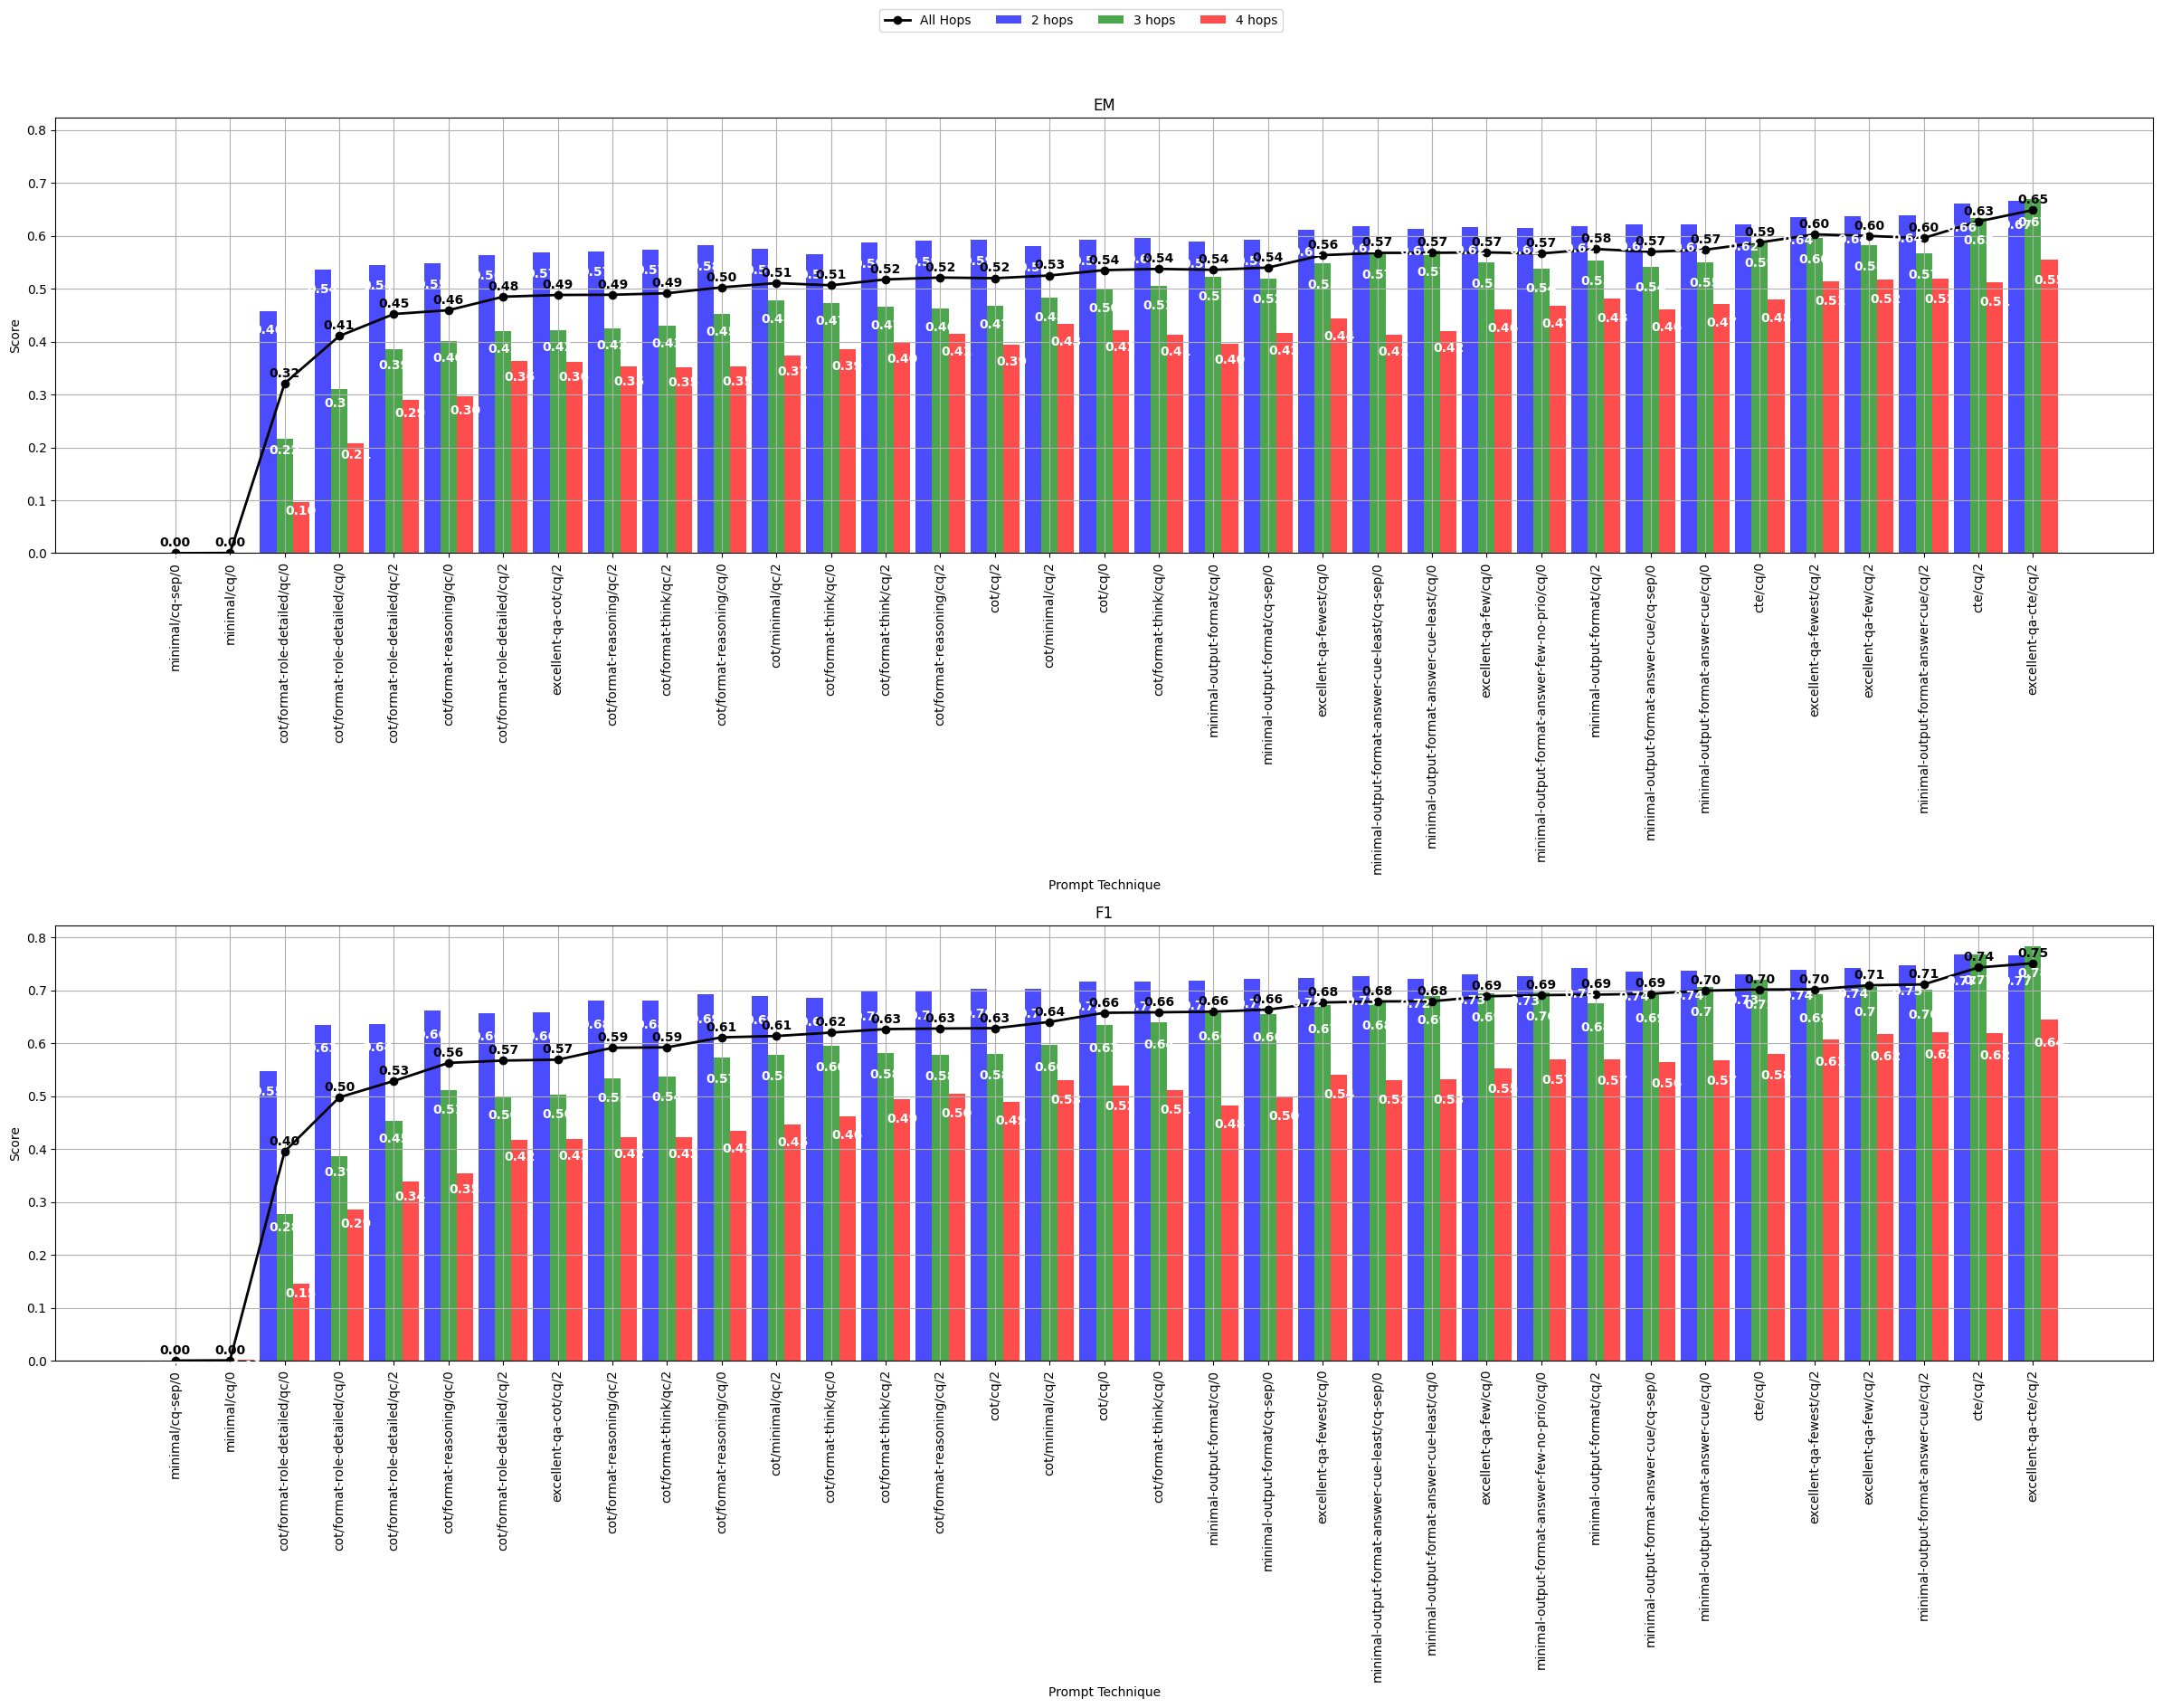

In [11]:
def plot_metric(df, metric, *, ax, title, width, ylabel=None):
    prompts = [
        f"{sp}/{up}/{fs}"
        for sp, up, fs in zip(
            df_target["params.qa.system_prompt"].values,
            df_target["params.qa.user_prompt_template"].values,
            df_target["params.qa.few_shot_examples"].values,
        )
    ]
    x = np.arange(len(prompts))
    metrics = {
        "2hops": df[f"metrics.2hops.{metric}"].values,
        "3hops": df[f"metrics.3hops.{metric}"].values,
        "4hops": df[f"metrics.4hops.{metric}"].values,
        "all": df[f"metrics.{metric}"].values,
    }
    bars_2hops = ax.bar(x - width, metrics["2hops"], width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + width, metrics["4hops"], width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=90)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18), sharey=True)

width = 0.3  # Bar width adjustment

# Changing the order of prompts to standard, cot-zs, cot-fs, cte

# Plotting Exact Match
plot_metric(df_target, 'exact_match', ax=ax1, title="EM", width=width, ylabel="Score")

# Plotting F1
plot_metric(df_target, 'f1', ax=ax2, title="F1", width=width, ylabel="Score")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()

In [12]:
mask = df_target['params.qa.few_shot_examples'] == 0
df_target.loc[mask].sort_values('metrics.f1', ascending=False).drop(columns=['params.qa.few_shot_examples'])

,params.qa.system_prompt,params.qa.user_prompt_template,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
16,cte.txt,cq.txt,0.587643,0.701567,0.651083,0.621938,0.729751,0.684505,0.589035,0.719814,0.665789,0.479012,0.580201,0.520165
27,minimal-output-format-answer-cue.txt,cq.txt,0.573714,0.699545,0.642670,0.621140,0.737700,0.694622,0.550439,0.706664,0.641228,0.470782,0.568233,0.484774
26,minimal-output-format-answer-cue.txt,cq-sep.txt,0.569852,0.693551,0.642256,0.622204,0.735943,0.698349,0.541228,0.692944,0.635965,0.461728,0.563641,0.480658
29,minimal-output-format-answer-few-no-prio.txt,cq.txt,0.566680,0.691031,0.636464,0.615548,0.726622,0.688765,0.538596,0.696723,0.629825,0.468313,0.570327,0.487243
20,excellent-qa-few.txt,cq.txt,0.568749,0.688877,0.636464,0.615815,0.729576,0.689031,0.549123,0.694474,0.631140,0.460082,0.552562,0.483951
25,minimal-output-format-answer-cue-least.txt,cq.txt,0.567922,0.679438,0.629017,0.612886,0.721228,0.674121,0.572368,0.689424,0.648684,0.420576,0.531514,0.452675
24,minimal-output-format-answer-cue-least.txt,cq-sep.txt,0.567784,0.679112,0.629982,0.618743,0.726717,0.681044,0.566228,0.679631,0.641667,0.413169,0.530976,0.450206
22,excellent-qa-fewest.txt,cq.txt,0.563508,0.677083,0.632051,0.612087,0.723825,0.679446,0.547368,0.672445,0.635526,0.443621,0.541292,0.479012
30,minimal-output-format.txt,cq-sep.txt,0.540063,0.663720,0.599366,0.593450,0.722551,0.664537,0.518421,0.655120,0.580702,0.415638,0.497995,0.432922
31,minimal-output-format.txt,cq.txt,0.535788,0.659685,0.592884,0.588658,0.718511,0.657614,0.522807,0.656993,0.580702,0.396708,0.482884,0.415638


In [13]:
mask = df_target['params.qa.system_prompt'].str.contains('cte')
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
19,excellent-qa-cte.txt,cq.txt,2,0.648738,0.751376,0.700041,0.666134,0.766371,0.721778,0.670175,0.783806,0.719298,0.554733,0.644163,0.596708
17,cte.txt,cq.txt,2,0.627224,0.743187,0.684181,0.660277,0.767688,0.723642,0.634211,0.768743,0.689035,0.511934,0.619488,0.553086
16,cte.txt,cq.txt,0,0.587643,0.701567,0.651083,0.621938,0.729751,0.684505,0.589035,0.719814,0.665789,0.479012,0.580201,0.520165


In [14]:
mask = df_target['params.qa.system_prompt'].str.contains('cot')
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
10,cot/format-think.txt,cq.txt,0,0.537443,0.658576,0.611364,0.596912,0.717388,0.666134,0.505702,0.640177,0.608333,0.413169,0.511291,0.447737
0,cot.txt,cq.txt,0,0.535237,0.657567,0.609157,0.593450,0.716771,0.663206,0.499561,0.633715,0.601754,0.422222,0.519304,0.455967
14,cot/minimal.txt,cq.txt,2,0.525031,0.640339,0.595228,0.580405,0.702500,0.648296,0.482456,0.596340,0.571053,0.433745,0.530739,0.476543
1,cot.txt,cq.txt,2,0.519928,0.628490,0.589850,0.592918,0.702337,0.661076,0.467105,0.580631,0.553509,0.393416,0.490011,0.437860
3,cot/format-reasoning.txt,cq.txt,2,0.521169,0.627879,0.586816,0.591587,0.698083,0.655751,0.462281,0.578346,0.547368,0.413992,0.503806,0.447737
11,cot/format-think.txt,cq.txt,2,0.517584,0.626776,0.587229,0.587327,0.697174,0.652822,0.466228,0.581750,0.557895,0.398354,0.493644,0.439506
12,cot/format-think.txt,qc.txt,0,0.506551,0.620156,0.576058,0.565761,0.686491,0.635783,0.473684,0.595633,0.567544,0.385185,0.461107,0.407407
15,cot/minimal.txt,qc.txt,2,0.510688,0.613684,0.576886,0.574814,0.689583,0.639776,0.477632,0.577926,0.564912,0.374486,0.446154,0.404938
2,cot/format-reasoning.txt,cq.txt,0,0.502689,0.611189,0.563508,0.581736,0.692121,0.641374,0.452193,0.572509,0.537719,0.353086,0.433584,0.371193
13,cot/format-think.txt,qc.txt,2,0.491518,0.592302,0.555234,0.574547,0.681161,0.641108,0.429386,0.536431,0.507895,0.351440,0.422450,0.378601


In [15]:
mask = ~df_target['params.qa.system_prompt'].str.contains('cot') & ~df_target['params.qa.system_prompt'].str.contains('cte')
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
28,minimal-output-format-answer-cue.txt,cq.txt,2,0.595918,0.711330,0.657702,0.638978,0.746748,0.709798,0.566228,0.701321,0.633772,0.518519,0.620622,0.541564
21,excellent-qa-few.txt,cq.txt,2,0.599779,0.709603,0.657978,0.637114,0.741893,0.709531,0.582018,0.705804,0.632895,0.517695,0.616911,0.545679
23,excellent-qa-fewest.txt,cq.txt,2,0.602813,0.702008,0.660874,0.635250,0.738326,0.704207,0.596491,0.692808,0.646491,0.514403,0.607001,0.553909
27,minimal-output-format-answer-cue.txt,cq.txt,0,0.573714,0.699545,0.642670,0.621140,0.737700,0.694622,0.550439,0.706664,0.641228,0.470782,0.568233,0.484774
26,minimal-output-format-answer-cue.txt,cq-sep.txt,0,0.569852,0.693551,0.642256,0.622204,0.735943,0.698349,0.541228,0.692944,0.635965,0.461728,0.563641,0.480658
32,minimal-output-format.txt,cq.txt,2,0.575093,0.691948,0.638808,0.618477,0.741548,0.691161,0.553947,0.675616,0.622368,0.480658,0.569264,0.507819
29,minimal-output-format-answer-few-no-prio.txt,cq.txt,0,0.566680,0.691031,0.636464,0.615548,0.726622,0.688765,0.538596,0.696723,0.629825,0.468313,0.570327,0.487243
20,excellent-qa-few.txt,cq.txt,0,0.568749,0.688877,0.636464,0.615815,0.729576,0.689031,0.549123,0.694474,0.631140,0.460082,0.552562,0.483951
25,minimal-output-format-answer-cue-least.txt,cq.txt,0,0.567922,0.679438,0.629017,0.612886,0.721228,0.674121,0.572368,0.689424,0.648684,0.420576,0.531514,0.452675
24,minimal-output-format-answer-cue-least.txt,cq-sep.txt,0,0.567784,0.679112,0.629982,0.618743,0.726717,0.681044,0.566228,0.679631,0.641667,0.413169,0.530976,0.450206
